In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from copy import deepcopy
from sklearn.utils import shuffle
from sklearn.metrics import root_mean_squared_error
import warnings
import itertools
warnings.filterwarnings("ignore", category=RuntimeWarning)
from IPython.core.debugger import set_trace

class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)
            w = w - self.learning_rate * grad
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

In [ ]:
# %%

class LinearRegression:
    def __init__(self, add_bias=True, lambdaa=0):
        self.add_bias = add_bias
        self.lambdaa = lambdaa
        pass

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None] # add a dimension for the features
        if self.add_bias:
            x = np.column_stack([x,np.ones(x.shape[0])]) # add bias 
        self.w = np.linalg.pinv(x.T @ x) @ x.T @ y
        return self
    
    def fit_gd(self, x, y, optimizer, reg_type='L1'):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        
        def gradient_l2(x, y, w):
            yh = x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            grad[1:] += self.lambdaa * w[1:]
            return grad
        def gradient_l1(x, y, w):
            yh = x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            grad[1:] += self.lambdaa * np.sign(w[1:])
            return grad
        if reg_type =='L2':
            w0 = np.zeros(D)
            self.w = optimizer.run(gradient_l2, x, y, w0)
        if reg_type =='L1':
            w0 = np.zeros(D)
            self.w = optimizer.run(gradient_l1, x, y, w0)
        return self
    
    def fit_reg(self, X, y, lambda_=0):
        # Convert pandas dataframes to numpy arrays
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values

        if self.add_bias:
            X = np.column_stack((np.ones(X.shape[0]), X))  # Adds bias feature X0

        # Add L2 regularization term lambda_ * I
        I = np.eye(X.shape[1])
        if self.add_bias:
            I[0, 0] = 0  # Do not regularize bias term

        # Regularized least squares solution
        w = np.linalg.pinv(X.T @ X + lambda_ * I) @ X.T @ y
        return w

    
    def find_gradient(self, X_batch, y_batch, W, max_grad_norm=50):
        N, D = X_batch.shape
        y_hat = X_batch @ W  # This is the dot product of X and W
                
        residuals = (y_hat - y_batch.flatten()) # Flatten y_batch if it's (N, 1)
        dW = (1/N) * np.dot(X_batch.T, residuals)  # X.T @ residuals

        grad_norm = np.linalg.norm(dW)

        if grad_norm > max_grad_norm:
            dW = dW * (max_grad_norm / grad_norm)
        return dW
    
    def compute_loss(self, X, y, W, lambda_l1=0, lambda_l2=0):
        N, D = X.shape
        y_pred = X @ W
        loss = (1/(2*N)) * np.sum((y_pred - y.flatten())**2)
        
        # Adding L1 and L2 penalty terms
        l1_penalty = lambda_l1 * np.sum(np.abs(W))
        l2_penalty = (lambda_l2 / 2) * np.sum(W**2)
    
        return loss + l1_penalty + l2_penalty

    def fit_gd_wz(self, X, y, learning_rate=5e-3, epochs=1000, tolerance=1e-6, max_grad_norm=50, momentum=0, lambda_l1=0, lambda_l2=0):
        X = X.values if isinstance(X, pd.DataFrame) else X
        y = y.values if isinstance(y, pd.DataFrame) else y

        if self.add_bias:
            X = np.column_stack((np.ones(X.shape[0]), X))

        m, n = X.shape
        weights = np.zeros(n)  # Initialize weights
        dW_momentum = weights.copy()
        losses = []  # Track losses for each epoch
        total_iterations = 0

        for epoch in range(epochs):
            total_iterations += 1

            # Compute gradient using the entire dataset (full batch)
            dW = self.find_gradient(X, y, weights, max_grad_norm)

            # Add L1 penalty gradient (sub-gradient) and L2 penalty
            dW += lambda_l1 * np.sign(weights) + lambda_l2 * weights

            # Update momentum with gradient
            dW_momentum = momentum * dW_momentum + (1 - momentum) * dW
            weights -= learning_rate * dW_momentum

            # Compute loss with L1/L2 regularization
            loss = self.compute_loss(X, y, weights, lambda_l1, lambda_l2)
            losses.append(loss)

            # Stopping condition based on loss
            if np.linalg.norm(dW) < tolerance or loss < tolerance:
                print(f"Converged at epoch: {epoch + 1} with loss: {loss:.6f}")
                break

        return weights, losses, total_iterations

    def fit_SVD(self, X, y, lambda_=0):
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
            
        if self.add_bias:
            X = np.column_stack((np.ones(X.shape[0]), X))
        
        # Perform Singular Value Decomposition (SVD)
        U, S, Vt = np.linalg.svd(X, full_matrices=False)
        
        # Apply L2 regularization by modifying singular values
        S_inv = np.diag(S / (S**2 + lambda_))  # Regularized inverse of the singular values

        # Calculate the weights using the pseudo-inverse from SVD
        beta = Vt.T @ S_inv @ U.T @ y
        
        return beta
    
    def predict(self, x):
        N = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w  # predict the y values
        return yh
    
    def predict_wz(self, X, w):
        if self.add_bias:
            X = np.column_stack((np.ones(X.shape[0]), X))

        y_hat = X @ w
        return y_hat


def split_data_train_val(x, y, ratio):
    x_shuf, y_shuf = shuffle(x, y, random_state=0)
    train_size = int(ratio * len(x_shuf))  
    
    x_train = x_shuf[:train_size]
    x_val = x_shuf[train_size:]
    y_train = y_shuf[:train_size]
    y_val = y_shuf[train_size:]
    
    return x_train, y_train, x_val, y_val


def compute_sse(yt, y_pred):
    squared_errors = (yt - y_pred) ** 2
    sse = np.sum(squared_errors)
    return sse
    
def get_gaussian_bases(yt, y, x):
    bases = np.linspace(0,100, 11)
    for i in bases:
        if i == 0: # linear model
            yh = model.fit(x,y).predict(x) 
            plt.plot(x, y, '.')
            plt.plot(x, yt, 'b-', label='ground truth')
            plt.plot(x, yh, 'g-', alpha=.5, label='linear fit')
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('No Gaussian bases')
            plt.legend()
            plt.show()
        else: # D = 10 to 100 gaussian bases
            D = int(i)
            mu = np.linspace(0,20,D)
            phi = gaussian(x[:,None], mu[None,:],1)
            for d in range(D):
                plt.plot(x, phi[:,d], '-')
            plt.xlabel('x')
            plt.title(str(D)+' Gaussian bases')
            plt.show()
            
            yh = model.fit(phi,y).predict(phi)
            fig, ax = plt.subplots()
            plt.plot(x, y, '.', label='noisy data')
            plt.plot(x, yt, 'b-', label='ground truth')
            plt.plot(x, yh, 'g-', label='prediction')
            plt.legend()
            plt.xlabel('x')
            plt.ylabel('y')
            plt.title('Curve-fitting using nonlinear Gaussian bases: D='+str(D))
            plt.show()

def test_sse_bases(yt, x_train, y_train, x_test, y_test):                    
    bases = np.linspace(0,100, 11)
    all_sse_train = []
    all_sse_test = []
    for base in bases:
        D = int(base)
        mu = np.linspace(0,20,D)
        if D == 0:
            # training set:
            yh = model.fit(x_train,y_train).predict(x_train)
            indices = np.argsort(x_train)
            x_train_sorted = x_train[indices]
            yh_sorted = yh[indices]
            # get the version of yt with just the sorted x_val
            y_short = y[np.isin(x, x_train_sorted)]
            sse_train = compute_sse(y_short, yh_sorted)
            all_sse_train.append(sse_train)
            # test set:
            yh = model.fit(x_train,y_train).predict(x_test)
            indices = np.argsort(x_test)
            x_test_sorted = x_test[indices]
            yh_sorted = yh[indices]
            # get the version of yt with just the sorted x_val
            y_short = y[np.isin(x, x_test_sorted)]
            sse_test = compute_sse(y_short, yh_sorted)
            all_sse_test.append(sse_test)
        else:
            # training set:
            phi_train = gaussian(x_train[:,None], mu[None,:],1)
            yh = model.fit(phi_train,y_train).predict(phi_train)
            indices = np.argsort(x_train)
            x_train_sorted = x_train[indices]
            yh_sorted = yh[indices]
            # get the version of yt with just the sorted x_val
            y_short = y[np.isin(x, x_train_sorted)]
            sse_train = compute_sse(y_short, yh_sorted)
            all_sse_train.append(sse_train)
            
            # test set:
            phi_test = gaussian(x_test[:,None], mu[None,:],1)
            yh = model.fit(phi_train,y_train).predict(phi_test)
            indices = np.argsort(x_test)
            x_test_sorted = x_test[indices]
            yh_sorted = yh[indices]
            # get the version of yt with just the sorted x_val
            y_short = y[np.isin(x, x_test_sorted)]
            sse_test = compute_sse(y_short, yh_sorted)
            all_sse_test.append(sse_test)
        
    # plot train and test errors from D = 10 to 100:
    plt.plot(bases, all_sse_train, 'b-', label='train error')
    plt.plot(bases, all_sse_test, 'g-', label='validation error')
    plt.title('Test and validation errors at different number of bases')
    plt.legend()
    plt.xlabel('D')
    plt.ylabel('SSE')
    plt.show()
    return

def test_variance_bias(yt):
    bases = np.linspace(10,100, 10)
    for base in bases:
        D = int(base)
        all_yh = []
        for i in range(10):
            y = yt + np.random.randn(N) # resample 100 data points + error 10 times
            mu = np.linspace(0,20,D)
            phi = gaussian(x[:,None], mu[None,:],1)
            yh = model.fit(phi,y).predict(phi)
            all_yh.append(yh)
            plt.plot(x, yh, 'g-', alpha=0.4)
    
        all_yh = np.asarray(all_yh)
        y_avg = np.mean(all_yh, axis=0)
        plt.plot(x, yt, 'b-', label='ground truth')
        plt.plot(x, y_avg, 'r-', label='average prediction')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.title('Variance and Bias for D='+str(D))
        plt.show()

def test_variance_bias_new_func():
    N = 100
    model = LinearRegression()
    gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
    x = np.linspace(0,20, N)
    yt = np.cos(x)**2 + np.exp(-2*x) - np.sin(x) + .5*x # true y function without noise
    bases = np.linspace(10,100, 10)
    
    for base in bases:
        D = int(base)
        all_yh = []
        for i in range(10):
            y = yt + np.random.randn(N) # resample 100 data points + error 10 times
            mu = np.linspace(0,20,D)
            phi = gaussian(x[:,None], mu[None,:],1)
            yh = model.fit(phi,y).predict(phi)
            all_yh.append(yh)
            plt.plot(x, yh, 'g-', alpha=0.4)
    
        all_yh = np.asarray(all_yh)
        y_avg = np.mean(all_yh, axis=0)
        plt.plot(x, yt, 'b-', label='ground truth')
        plt.plot(x, y_avg, 'r-', label='average prediction')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.title(r'Variance and Bias for $f(x) = \cos^2(x) + e^{-2x} - \sin(x) + 0.5x$ for D='+str(D))
        plt.show()
        
def get_train_test_errors(yt):                    
    bases = np.linspace(0,100, 11)
    avg_train_errors = []
    avg_test_errors = []
    for base in bases:
        D = int(base)
        all_sse_train = []
        all_sse_test = []
        for i in range(10):
            y = yt + np.random.randn(N) # resample 100 data points + error 10 times
            x_train, y_train, x_test, y_test = split_data_train_val(x, y, 0.8)
            mu = np.linspace(0,20,D)
            if D == 0:
                # training set:
                yh = model.fit(x_train,y_train).predict(x_train)
                indices = np.argsort(x_train)
                x_train_sorted = x_train[indices]
                yh_sorted = yh[indices]
                # get the version of yt with just the sorted x_val
                y_short = yt[np.isin(x, x_train_sorted)]
                sse_train = compute_sse(y_short, yh_sorted)
                all_sse_train.append(sse_train)
                # test set:
                yh = model.fit(x_train,y_train).predict(x_test)
                indices = np.argsort(x_test)
                x_test_sorted = x_test[indices]
                yh_sorted = yh[indices]
                # get the version of yt with just the sorted x_val
                y_short = y[np.isin(x, x_test_sorted)]
                sse_test = compute_sse(y_short, yh_sorted)
                all_sse_test.append(sse_test)
            else:
                # training set:
                phi_train = gaussian(x_train[:,None], mu[None,:],1)
                yh = model.fit(phi_train,y_train).predict(phi_train)
                indices = np.argsort(x_train)
                x_train_sorted = x_train[indices]
                yh_sorted = yh[indices]
                # get the version of yt with just the sorted x_val
                y_short = y[np.isin(x, x_train_sorted)]
                sse_train = compute_sse(y_short, yh_sorted)
                all_sse_train.append(sse_train)
                
                # test set:
                phi_test = gaussian(x_test[:,None], mu[None,:],1)
                yh = model.fit(phi_train,y_train).predict(phi_test)
                indices = np.argsort(x_test)
                x_test_sorted = x_test[indices]
                yh_sorted = yh[indices]
                # get the version of yt with just the sorted x_val
                y_short = y[np.isin(x, x_test_sorted)]
                sse_test = compute_sse(y_short, yh_sorted)
                all_sse_test.append(sse_test)
        
        avg_sse_train = np.average(all_sse_train)
        avg_sse_test = np.average(all_sse_test)
        avg_train_errors.append(avg_sse_train)
        avg_test_errors.append(avg_sse_test)
        # print('Average training SSE for D='+str(D)+': '+str(avg_sse_train))
        # print('Average test SSE for D='+str(D)+': '+str(avg_sse_test))
        # print()
        
    # plot train and test errors from D = 10 to 100:
    plt.plot(bases, avg_train_errors, 'b-', label='train error')
    plt.plot(bases, avg_test_errors, 'g-', label='test error')
    plt.title('Average Test and Train Errors')
    plt.legend()
    plt.xlabel('D')
    plt.ylabel('SSE')
    plt.show()
    return

def test_noise_and_variance_bias(yt):
    noise_stdev = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]
    for stdev in noise_stdev:
        D = 20
        all_yh = []
        for i in range(10):
            y = yt + np.random.normal(0, 1.5, N) # resample 100 data points + error 10 times
            mu = np.linspace(0,20,D)
            phi = gaussian(x[:,None], mu[None,:],1)
            yh = model.fit(phi,y).predict(phi)
            all_yh.append(yh)
            plt.plot(x, yh, 'g-', alpha=0.4)
        
        all_yh = np.asarray(all_yh)
        y_avg = np.mean(all_yh, axis=0)
        plt.plot(x, yt, 'b-', label='ground truth')
        plt.plot(x, y_avg, 'r-', label='average prediction')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.title('Variance and Bias (D=20) for noise standard deviation='+str(stdev))
        plt.show()

def test_noise_train_test_errors(yt):
    noise_stdev = [0.1, 0.5, 1, 1.5, 2, 2.5, 3]    
    avg_train_errors = []
    avg_test_errors = []
    for stdev in noise_stdev:
        D = 20
        all_sse_train = []
        all_sse_test = []
        for i in range(10):
            y = yt + np.random.normal(0, 1.5, N) # resample 100 data points + error 10 times
            x_train, y_train, x_test, y_test = split_data_train_val(x, y, 0.8)
            mu = np.linspace(0,20,D)
    
            # training set:
            phi_train = gaussian(x_train[:,None], mu[None,:],1)
            yh = model.fit(phi_train,y_train).predict(phi_train)
            indices = np.argsort(x_train)
            x_train_sorted = x_train[indices]
            yh_sorted = yh[indices]
            # get the version of yt with just the sorted x_val
            yt_short = yt[np.isin(x, x_train_sorted)]
            sse_train = compute_sse(yt_short, yh_sorted)
            all_sse_train.append(sse_train)
            
            # test set:
            phi_test = gaussian(x_test[:,None], mu[None,:],1)
            yh = model.fit(phi_train,y_train).predict(phi_test)
            indices = np.argsort(x_test)
            x_test_sorted = x_test[indices]
            yh_sorted = yh[indices]
            # get the version of yt with just the sorted x_val
            yt_short = yt[np.isin(x, x_test_sorted)]
            sse_test = compute_sse(yt_short, yh_sorted)
            all_sse_test.append(sse_test)
        
        avg_sse_train = np.average(all_sse_train)
        avg_sse_test = np.average(all_sse_test)
        avg_train_errors.append(avg_sse_train)
        avg_test_errors.append(avg_sse_test)
        
    # plot train and test errors from D = 10 to 100:
    plt.plot(noise_stdev, avg_train_errors, 'b-', label='train error')
    plt.plot(noise_stdev, avg_test_errors, 'g-', label='test error')
    plt.title('Average Test and Train Errors')
    plt.legend()
    plt.xlabel('Noise standard deviation')
    plt.ylabel('SSE')
    plt.show()

def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

def visualize_gd(x, y, reg_type):
    cost = lambda w, reg: .5*np.mean((w[0] + w[1]*x - y)**2) + reg*np.dot(w,w)/2
    reg_list = [0, 0.1, 1, 10, 100]
    fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(20, 5))
    if reg_type == "L2": # L2 regularized
        for i, reg_coef in enumerate(reg_list):
            optimizer = GradientDescent(learning_rate=.01, max_iters=5000, record_history=True)
            model = LinearRegression(optimizer, lambdaa=reg_coef)
            model.fit_gd(x,y, optimizer, reg_type='L2')
            current_cost = lambda w: cost(w, reg_coef)
            plot_contour(current_cost, [-20,20], [-5,5], 50, axes[i])
            w_hist = np.vstack(optimizer.w_history)# T x 2
            axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
            axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
            axes[i].set_xlabel(r'$w_0$')
            axes[i].set_ylabel(r'$w_1$')
            axes[i].set_title(f' lambda = {reg_coef}')
            axes[i].set_xlim([-20,20])
            axes[i].set_ylim([-5,5])
        fig.suptitle('Gradient Descent Paths with L2 Regularization', fontsize=18)
        plt.show()
    if reg_type =="L1": # L1 regularized:
        for i, reg_coef in enumerate(reg_list):
            optimizer = GradientDescent(learning_rate=.01, max_iters=5000, record_history=True)
            model = LinearRegression(optimizer, lambdaa=reg_coef)
            model.fit_gd(x,y, optimizer, reg_type='L1')
            current_cost = lambda w: cost(w, reg_coef)
            plot_contour(current_cost, [-20,20], [-5,5], 50, axes[i])
            w_hist = np.vstack(optimizer.w_history)# T x 2
            axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
            axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
            axes[i].set_xlabel(r'$w_0$')
            axes[i].set_ylabel(r'$w_1$')
            axes[i].set_title(f' lambda = {reg_coef}')
            axes[i].set_xlim([-20,20])
            axes[i].set_ylim([-5,5])
        fig.suptitle('Gradient Descent Paths with L1 Regularization', fontsize=18)
        plt.show()

def l1_loss_functions():
    cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
    l1_penalty = lambda w: np.sum(np.abs(w))
    reg_list = [0, 0.1, 1, 10, 100]
    fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(20, 5))
    fig.suptitle('L1 Regularized Loss Functions', fontsize=18)
    for i, reg_coef in enumerate(reg_list):
        cost_plus_l1 = lambda w: cost(w) + reg_coef*l1_penalty(w)
        plot_contour(cost_plus_l1, [-20,20], [-20,20], 50, axes[i])
        axes[i].set_title(r'$J(w)$ = cost +'+str(reg_coef)+r'$||w||_1$')
    plt.show()
    return

def l2_loss_functions():
    cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
    l2_penalty = lambda w: np.dot(w,w)/2
    reg_list = [0, 0.1, 1, 10, 100]
    fig, axes = plt.subplots(ncols=len(reg_list), nrows=1, constrained_layout=True, figsize=(20, 5))
    fig.suptitle('L2 Regularized Loss Functions', fontsize=18)
    for i, reg_coef in enumerate(reg_list):
        cost_plus_l2 = lambda w: cost(w) + reg_coef*l2_penalty(w)
        plot_contour(cost_plus_l2, [-20,20], [-20,20], 50, axes[i])
        axes[i].set_title(r'$J(w)$ = cost +'+str(reg_coef)+r'$||w||_2^2$')
    plt.show()
    return

def test_train_val_split_wz(X,y,test_size=0.2,val_size=0.2,train_size=0.6):
    if(test_size+val_size+train_size!=1):
        print("Sizes must add to 1")
        return
    # Shuffle the data indices
    X = np.array(X)
    y = np.array(y)
    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)
    
    # Calculate the split indices
    train_end = int(train_size * data_size)
    val_end = int((train_size + val_size) * data_size)
    
    # Split the indices for training, validation, and test sets
    train_indices = indices[:train_end]
    val_indices = indices[train_end:val_end]
    test_indices = indices[val_end:]
    
    # Split the data using these indices
    X_train, y_train = X[train_indices], y[train_indices]
    X_val, y_val = X[val_indices], y[val_indices]
    X_test, y_test = X[test_indices], y[test_indices]

    train_sorted_indices = np.argsort(X_train)
    X_train_sorted = X_train[train_sorted_indices]
    y_train_sorted = y_train[train_sorted_indices]

    val_sorted_indices = np.argsort(X_val)
    X_val_sorted = X_val[val_sorted_indices]
    y_val_sorted = y_val[val_sorted_indices]

    test_sorted_indices = np.argsort(X_test)
    X_test_sorted = X_test[test_sorted_indices]
    y_test_sorted = y_test[test_sorted_indices]
    
    return X_train_sorted, y_train_sorted, X_val_sorted, y_val_sorted, X_test_sorted, y_test_sorted

In [ ]:
# %%

def taskSVD_VSREG(X_loc, y_loc, model: LinearRegression, num, k, l2_vals):
    # Generate k folds for cross-validation
    folds, X_test, y_test = kfold_wz(X_loc, y_loc, k)
    
    least_squares_train_errors = []
    least_squares_val_errors = []
    svd_train_errors = []
    svd_val_errors = []
    
    for lambda_l2 in l2_vals:
        validation_errors_ls = []
        training_errors_ls = []
        validation_errors_svd = []
        training_errors_svd = []
        
        for i in range(k):
            val_slice = folds[i]
            train_slices = [folds[j] for j in range(k) if j != i]

            X_train = np.concatenate([data[0] for data in train_slices])
            y_train = np.concatenate([data[1] for data in train_slices])
                
            # Validation fold
            X_val = val_slice[0]
            y_val = val_slice[1]
            
            # Transform with Gaussian basis
            phi_train = gaussian_transform_wz(X_train, False, num)
            phi_val = gaussian_transform_wz(X_val, False, num)
            
            # Fitting with least squares (normal equations)
            weights_ls = model.fit_reg(phi_train, y_train, lambda_=lambda_l2)
            
            # Fitting with SVD
            weights_svd = model.fit_SVD(phi_train, y_train, lambda_=0)
            
            # Prediction and error calc for least squares
            y_train_pred_ls = model.predict_wz(phi_train, weights_ls)
            train_error_ls = np.mean((y_train - y_train_pred_ls) ** 2)
            training_errors_ls.append(train_error_ls)
            
            y_val_pred_ls = model.predict_wz(phi_val, weights_ls)
            val_error_ls = np.mean((y_val - y_val_pred_ls) ** 2)
            validation_errors_ls.append(val_error_ls)

            # Prediction and error calc for SVD
            y_train_pred_svd = model.predict_wz(phi_train, weights_svd)
            train_error_svd = np.mean((y_train - y_train_pred_svd) ** 2)
            training_errors_svd.append(train_error_svd)

            y_val_pred_svd = model.predict_wz(phi_val, weights_svd)
            val_error_svd = np.mean((y_val - y_val_pred_svd) ** 2)
            validation_errors_svd.append(val_error_svd)
               
        least_squares_train_errors.append(np.mean(training_errors_ls))
        least_squares_val_errors.append(np.mean(validation_errors_ls))
        svd_train_errors.append(np.mean(training_errors_svd))
        svd_val_errors.append(np.mean(validation_errors_svd))
    
    # Plot least squares training and validation errors
    plt.figure(figsize=(10, 6))
    plt.plot(l2_vals, least_squares_train_errors, label='Training Error (Least Squares)', color='blue', marker='o', linestyle='--')
    plt.plot(l2_vals, least_squares_val_errors, label='Validation Error (Least Squares)', color='red', marker='o', linestyle='-')
    plt.xscale('log')
    plt.xlabel('Regularization Strength (λ)')
    plt.ylabel('Error')
    
   
    plt.plot(l2_vals, svd_train_errors, label='Training Error (SVD)', color='green', marker='*', linestyle='--')
    plt.plot(l2_vals, svd_val_errors, label='Validation Error (SVD)', color='orange', marker='*', linestyle='-')
    plt.xscale('log')
    plt.xlabel('Regularization Strength (λ)')
    plt.ylabel('Error')
    plt.title('Training and Validation Errors for Least Squares and SVD')
    plt.legend()
    plt.grid(True)
    plt.show()

    return least_squares_train_errors, least_squares_val_errors, svd_train_errors, svd_val_errors

def kfold_wz(X,y,k,test_ratio=0.1):
    X = np.array(X)
    y = np.array(y)
    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)
    folds=[]

    fold_end = int((1-test_ratio) * data_size)

    fold_indices = indices[:fold_end]
    test_indices = indices[fold_end:]


    X_fold, y_fold = X[fold_indices], y[fold_indices]
    fold_size = len(fold_indices)//k
    for i in range(k):
        
        if i == k - 1: #last fold may be weird
            xf = X_fold[i * fold_size:]
            yf = y_fold[i * fold_size:]
        else:
            xf = X_fold[i * fold_size:(i + 1) * fold_size]
            yf = y_fold[i * fold_size:(i + 1) * fold_size]
        
        folds.append([xf, yf])
    
    #Get test indices out
    X_test, y_test = X[test_indices], y[test_indices]
    #test_sorted_indices = np.argsort(X_test)
    #X_test_sorted = X_test[test_sorted_indices]
    #y_test_sorted = y_test[test_sorted_indices]

    return folds, X_test, y_test

def kfold_true_wz(X,y,yt,k,test_ratio=0.1):
    X = np.array(X)
    y = np.array(y)
    yt = np.array(yt)    
    data_size = len(X)
    indices = np.arange(data_size)
    np.random.shuffle(indices)
    folds=[]

    fold_end = int((1-test_ratio) * data_size)

    fold_indices = indices[:fold_end]
    test_indices = indices[fold_end:]


    X_fold, y_fold, yt_fold = X[fold_indices], y[fold_indices],yt[fold_indices]
    fold_size = len(fold_indices)//k
    for i in range(k):
        
        if i == k - 1: #last fold may be weird
            xf = X_fold[i * fold_size:]
            yf = y_fold[i * fold_size:]
            ytf = yt_fold[i * fold_size:]
        else:
            xf = X_fold[i * fold_size:(i + 1) * fold_size]
            yf = y_fold[i * fold_size:(i + 1) * fold_size]
            ytf = yt_fold[i * fold_size:(i + 1) * fold_size]
        
        folds.append([xf, yf,ytf])
    
    #Get test indices out
    X_test, y_test, y_true_test = X[test_indices], y[test_indices], yt[test_indices]
    #test_sorted_indices = np.argsort(X_test)
    #X_test_sorted = X_test[test_sorted_indices]
    #y_test_sorted = y_test[test_sorted_indices]

    return folds, X_test, y_test, y_true_test

In [ ]:
#%%

def gen_samples_wz(num_points, sigma=1):
    X = np.linspace(0,20, num=num_points)

    y=[0]*num_points
    y_true=[0]*num_points
    mu = 0 # mean and standard deviation
    epsilons = np.random.normal(mu, sigma, num_points)
    for i in range(0,num_points):
        x= X[i]
        
        val = np.sin(np.sqrt(x))+np.cos(x)+np.sin(x)
        
        y_true[i]=val
        
        y[i]=val+epsilons[i]
    return X,y,y_true

def gaussian_transform_wz(X, plot,num_features):
   
    phi = np.zeros((len(X),num_features))
    mu_values = np.linspace(0,20, num=num_features) #Create values for 
    sigma =1
    for col in range(num_features):
            phi[:,col] = np.exp(- (X - mu_values[col]) ** 2 / (2 * sigma ** 2))

    # for col in range(num_features):
    #     phi[:, col] = X ** (col + 1)  # Polynomial terms x^1, x^2, ..., x^num_features
    
    # for col in range(num_features):
    #     frequency = (col // 2) + 1  # Increase frequency with each pair of sine/cosine
    #     if col % 2 == 0:
    #         phi[:, col] = np.sin(2 * np.pi * frequency * X)  # sine basis
    #     else:
    #         phi[:, col] = np.cos(2 * np.pi * frequency * X)  # cosine basis

    if(plot):
            plt.figure(figsize=(10, 6))
            for col in range(num_features):
                #plt.plot(X, phi[:, col], label=f'Gaussian {col+1} (mu={mu_values[col]:.2f})')
                 plt.plot(X, phi[:, col], label=f'Polynomial x^{col+1}')
            # Add plot details
            plt.title(f'Gaussian Basis Functions (D={num_features})')
            plt.xlabel('X')
            plt.ylabel('Basis Function Value')
            plt.legend(loc='upper right')
            plt.grid(True)
            plt.show()


    return phi

In [ ]:
# %%

def task3_1_wz(model: LinearRegression, num,k, l1_vals, l2_vals):
    X, y, y_true = gen_samples_wz(20,sigma=2)

    folds, X_test, y_test = kfold_wz(X,y,k)
   
    l1_train_errors = []
    l1_val_errors = []
    l2_train_errors = []
    l2_val_errors = []
    for lambda_l1, lambda_l2 in zip(l1_vals, l2_vals):
        validation_errors_l1 = []
        training_errors_l1 = []
        validation_errors_l2 = []
        training_errors_l2 = []
            
        for i in range(k):
            
            val_slice = folds[i]
            train_slices = [folds[j] for j in range(k) if j != i]

            X_train = np.concatenate([data[0] for data in train_slices])
            y_train = np.concatenate([data[1] for data in train_slices])

            # Validation fold
            X_val = val_slice[0]
            y_val = val_slice[1]
            
            phi_train = gaussian_transform_wz(X_train, False, num)
            phi_val = gaussian_transform_wz(X_val, False, num)
           

            weights_l1, _, _ = model.fit_gd_wz(phi_train, y_train, lambda_l1=lambda_l1, lambda_l2=0)
            weights_l2, _, _ = model.fit_gd_wz(phi_train, y_train, lambda_l1=0, lambda_l2=lambda_l2)
            
            #prediction and error calc for lasso
            y_train_pred_l1 = model.predict_wz(phi_train, weights_l1)
            train_error_l1 = np.mean((y_train - y_train_pred_l1) ** 2)
            training_errors_l1.append(train_error_l1)
            
            y_val_pred_l1 = model.predict_wz(phi_val, weights_l1)
            val_error_l1 = np.mean((y_val - y_val_pred_l1) ** 2)
            validation_errors_l1.append(val_error_l1)

            #prediction and error calc for ridge
            y_train_pred_l2 = model.predict_wz(phi_train, weights_l2)
            train_error_l2 = np.mean((y_train - y_train_pred_l2) ** 2)
            training_errors_l2.append(train_error_l2)

            y_val_pred_l2 = model.predict_wz(phi_val, weights_l2)
            val_error_l2 = np.mean((y_val - y_val_pred_l2) ** 2)
            validation_errors_l2.append(val_error_l2)

               
        l1_train_errors.append(np.mean(training_errors_l1))
        l1_val_errors.append(np.mean(validation_errors_l1))
        l2_train_errors.append(np.mean(training_errors_l2))
        l2_val_errors.append(np.mean(validation_errors_l2))
    
    plt.figure(figsize=(10, 6))
    plt.plot(l1_vals, l1_train_errors, label='Training Error (L1)', color='blue', marker='o', linestyle='--')
    plt.plot(l1_vals, np.array(l1_val_errors), label='Scaled Validation Error (L1)', color='red', marker='o', linestyle='-')
    plt.xscale('log')
    plt.xlabel('Regularization Strength (λ)')
    plt.ylabel('Error')
    plt.title('Training and Validation for L1 Regularization')
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(l2_vals, l2_train_errors, label='Training Error (L2)', color='blue', marker='o', linestyle='--')
    plt.plot(l2_vals, np.array(l2_val_errors), label='Validation Error (L2)', color='red', marker='o', linestyle='-')
    plt.xscale('log')
    plt.xlabel('Regularization Strength (λ)')
    plt.ylabel('Error')
    plt.title('Training and Validation, and Test Errors for L2 Regularization')
    plt.legend()
    plt.grid(True)
    plt.show()
    index_of_min_l1 = l1_val_errors.index(min(l1_val_errors))
    index_of_min_l2 = l2_val_errors.index(min(l2_val_errors))

    return l1_train_errors, l1_val_errors, l2_train_errors, l2_val_errors

In [ ]:
#%%

def task3_2_wz(model: LinearRegression, num_features, k, l1_vals, l2_vals, num_datasets, noise_variance=1.0):
    # Generate synthetic data
    y_sets = []
    y_truesets = []
    x_true, y_val, y_true = gen_samples_wz(20, sigma=1)  # Validation set for comparison without noise
    l1_train_errors = np.zeros((len(l1_vals), num_datasets))  # Initialize error matrices
    l1_test_errors = np.zeros((len(l1_vals), num_datasets))
    l2_train_errors = np.zeros((len(l2_vals), num_datasets))
    l2_test_errors = np.zeros((len(l2_vals), num_datasets))
   
    l1_biases = np.zeros((len(l1_vals), num_datasets))
    l1_variances = np.zeros((len(l1_vals), num_datasets))
    l2_biases = np.zeros((len(l2_vals), num_datasets))
    l2_variances = np.zeros((len(l2_vals), num_datasets))

    for dataset_idx in range(num_datasets):
        print(f'Starting Dataset {dataset_idx+1}/{num_datasets}')
        x,y,y_true = gen_samples_wz(100) #generate dataset
        
        idx=0
        for lambda1, lambda2 in zip(l1_vals, l2_vals):
            total_bias_l1 = 0
            total_variance_l1 = 0
            total_bias_l2 = 0
            total_variance_l2 = 0
            total_train_error_l1 = 0
            total_test_error_l1 = 0
            total_train_error_l2 = 0
            total_test_error_l2 = 0

            folds, xtest,ytest,y_test_true = kfold_true_wz(x,y,y_true,k) 
            
            phi_test = gaussian_transform_wz(xtest, False, num_features)
            predictions_l1 = []
            predictions_l2 = []
            for f in range(k):
                X_fold, y_fold, yt_fold = folds[f]
                X_train_folds = np.concatenate([folds[i][0] for i in range(k) if i != f], axis=0)
                y_train_folds = np.concatenate([folds[i][1] for i in range(k) if i != f], axis=0)
                yt_train_folds = np.concatenate([folds[i][2] for i in range(k) if i != f], axis=0)

                sorted_indices = np.argsort(X_train_folds)  # Assuming sorting by the first column
                X_train_folds = X_train_folds[sorted_indices]
                y_train_folds = y_train_folds[sorted_indices]
                yt_train_folds = yt_train_folds[sorted_indices]

                phi = gaussian_transform_wz(X_train_folds,False,num_features)

                if(f==0 and idx==0):
                    print(np.shape(phi))
                #get weights
                weightsl1, _, _ = model.fit_gd_wz(phi, y_train_folds,lambda_l1=lambda1, lambda_l2=0)
                weightsl2, _, _ = model.fit_gd_wz(phi, y_train_folds,lambda_l1=0, lambda_l2=lambda2)
                #predict with test values
                pred_testl1 = model.predict_wz(phi_test, weightsl1)
                pred_testl2 = model.predict_wz(phi_test, weightsl2)
                #predict with train values
                pred_trainl1 = model.predict_wz(phi, weightsl1)
                pred_trainl2 = model.predict_wz(phi, weightsl2)
                #compute MSE for train 
                predictions_l1.append(pred_testl1)
                predictions_l2.append(pred_testl2)
                train_error_l1 = root_mean_squared_error(y_train_folds,pred_trainl1)**2
                train_error_l2 = root_mean_squared_error(y_train_folds,pred_trainl2)**2
                #Computer MSE for test
                test_error_l1 = root_mean_squared_error(ytest,pred_testl1)**2
                test_error_l2 = root_mean_squared_error(ytest,pred_testl2)**2

                # Accumulate train and test errors across folds
                total_train_error_l1 += train_error_l1
                total_train_error_l2 += train_error_l2
                total_test_error_l1 += test_error_l1
                total_test_error_l2 += test_error_l2

                #Compute the bias as MSE
                bias_fold_l1 = np.mean((pred_testl1 - y_test_true) ** 2)  # Squared error for bias
                bias_fold_l2 = np.mean((pred_testl2 - y_test_true) ** 2)

                # Accumulate the bias
                total_bias_l1 += bias_fold_l1
                total_bias_l2 += bias_fold_l2

            predictions_l1 = np.array(predictions_l1)
            predictions_l2 = np.array(predictions_l2)

            # Variance is the average deviation of the predictions from the mean prediction
            avg_prediction_l1 = np.mean(predictions_l1, axis=0)
            avg_prediction_l2 = np.mean(predictions_l2, axis=0)

            variance_fold_l1 = np.mean(np.var(predictions_l1, axis=0))  # Variance of predictions
            variance_fold_l2 = np.mean(np.var(predictions_l2, axis=0))

            avg_bias_l1 = total_bias_l1 / k
            avg_bias_l2 = total_bias_l2 / k
            avg_variance_l1 = variance_fold_l1
            avg_variance_l2 = variance_fold_l2

            avg_train_error_l1 = total_train_error_l1 / k
            avg_train_error_l2 = total_train_error_l2 / k
            avg_test_error_l1 = total_test_error_l1 / k
            avg_test_error_l2 = total_test_error_l2 / k

            # After computing averages from K folds
            # Store the average errors, bias, and variance for this dataset and lambda
            l1_train_errors[idx, dataset_idx] = avg_train_error_l1
            l1_test_errors[idx, dataset_idx] = avg_test_error_l1
            l2_train_errors[idx, dataset_idx] = avg_train_error_l2
            l2_test_errors[idx, dataset_idx] = avg_test_error_l2

            l1_biases[idx, dataset_idx] = avg_bias_l1
            l1_variances[idx, dataset_idx] = np.mean(np.var(predictions_l1, axis=0))
            l2_biases[idx, dataset_idx] = avg_bias_l2
            l2_variances[idx, dataset_idx] = np.mean(np.var(predictions_l2, axis=0))
            idx+=1 #iterate idx val
       
    avg_l1_train_error = np.mean(l1_train_errors, axis=1)
    avg_l1_test_error = np.mean(l1_test_errors, axis=1)
    avg_l1_bias = np.mean(l1_biases, axis=1)
    avg_l1_variance = np.mean(l1_variances, axis=1)

    avg_l2_train_error = np.mean(l2_train_errors, axis=1)
    avg_l2_test_error = np.mean(l2_test_errors, axis=1)
    avg_l2_bias = np.mean(l2_biases, axis=1)
    avg_l2_variance = np.mean(l2_variances, axis=1)


    # Compute Bias² for L1 and L2
    bias_squared_l1 = avg_l1_bias ** 2
    bias_squared_l2 = avg_l2_bias ** 2

    # Compute Bias² + Variance for L1 and L2
    bias_variance_l1 = bias_squared_l1 + avg_l1_variance
    bias_variance_l2 = bias_squared_l2 + avg_l2_variance

    # Compute Bias² + Variance + Noise Variance for L1 and L2
    bias_variance_noise_l1 = bias_variance_l1 + noise_variance
    bias_variance_noise_l2 = bias_variance_l2 + noise_variance

    # Create figure and subplots
    fig, axs = plt.subplots(4, 2, figsize=(12, 15))  # Three rows, two columns of subplots

    # Plot Bias² for L1 Regularization (on its own plot)
    axs[0, 0].plot(l1_vals, bias_squared_l1, label='Bias²', marker='o', color='blue')
    axs[0, 0].set_xlabel('L1 Regularization Strength (lambda)')
    axs[0, 0].set_ylabel('Bias²')
    axs[0, 0].set_title('L1 Bias²')
    axs[0, 0].set_xscale('log')
    axs[0, 0].legend()

    # Plot Bias² for L2 Regularization (on its own plot)
    axs[0, 1].plot(l2_vals, bias_squared_l2, label='Bias²', marker='o', color='blue')
    axs[0, 1].set_xlabel('L2 Regularization Strength (lambda)')
    axs[0, 1].set_ylabel('Bias²')
    axs[0, 1].set_title('L2 Bias²')
    axs[0, 1].set_xscale('log')
    axs[0, 1].legend()

    # Plot Bias² + Variance and Bias² + Variance + Noise for L1 Regularization
    axs[1, 0].plot(l1_vals, bias_variance_l1, label='Bias² + Variance', marker='o', color='green')
    axs[1, 0].plot(l1_vals, bias_variance_noise_l1, label='Bias² + Variance + Noise', marker='o', color='red')
    axs[1, 0].set_xlabel('L1 Regularization Strength (lambda)')
    axs[1, 0].set_ylabel('Total Error')
    axs[1, 0].set_title('L1 Bias² + Variance and Total Error')
    axs[1, 0].set_xscale('log')
    axs[1, 0].legend()

    # Plot Bias² + Variance and Bias² + Variance + Noise for L2 Regularization
    axs[1, 1].plot(l2_vals, bias_variance_l2, label='Bias² + Variance', marker='o', color='green')
    axs[1, 1].plot(l2_vals, bias_variance_noise_l2, label='Bias² + Variance + Noise', marker='o', color='red')
    axs[1, 1].set_xlabel('L2 Regularization Strength (lambda)')
    axs[1, 1].set_ylabel('Total Error')
    axs[1, 1].set_title('L2 Bias² + Variance and Total Error')
    axs[1, 1].set_xscale('log')
    axs[1, 1].legend()

    # Plot Variance for L1 Regularization separately
    axs[2, 0].plot(l1_vals, avg_l1_variance, label='Variance', color='orange', marker='o')
    axs[2, 0].set_xlabel('L1 Regularization Strength (lambda)')
    axs[2, 0].set_ylabel('Variance')
    axs[2, 0].set_title('L1 Variance')
    axs[2, 0].set_xscale('log')
    axs[2, 0].legend()

    # Plot Variance for L2 Regularization separately
    axs[2, 1].plot(l2_vals, avg_l2_variance, label='Variance', color='orange', marker='o')
    axs[2, 1].set_xlabel('L2 Regularization Strength (lambda)')
    axs[2, 1].set_ylabel('Variance')
    axs[2, 1].set_title('L2 Variance')
    axs[2, 1].set_xscale('log')
    axs[2, 1].legend()

    # Plot Training and Test Error for L1 Regularization
    axs[3, 0].plot(l1_vals, avg_l1_train_error, label='Train Error', marker='o', color='purple')
    axs[3, 0].plot(l1_vals, avg_l1_test_error, label='Test Error', marker='o', color='brown')
    axs[3, 0].set_xlabel('L1 Regularization Strength (lambda)')
    axs[3, 0].set_ylabel('Error')
    axs[3, 0].set_title('L1 Train vs Test Error')
    axs[3, 0].set_xscale('log')
    axs[3, 0].legend()

    # Plot Training and Test Error for L2 Regularization
    axs[3, 1].plot(l2_vals, avg_l2_train_error, label='Train Error', marker='o', color='purple')
    axs[3, 1].plot(l2_vals, avg_l2_test_error, label='Test Error', marker='o', color='brown')
    axs[3, 1].set_xlabel('L2 Regularization Strength (lambda)')
    axs[3, 1].set_ylabel('Error')
    axs[3, 1].set_title('L2 Train vs Test Error')
    axs[3, 1].set_xscale('log')
    axs[3, 1].legend()

    plt.tight_layout()

    
    plt.show()

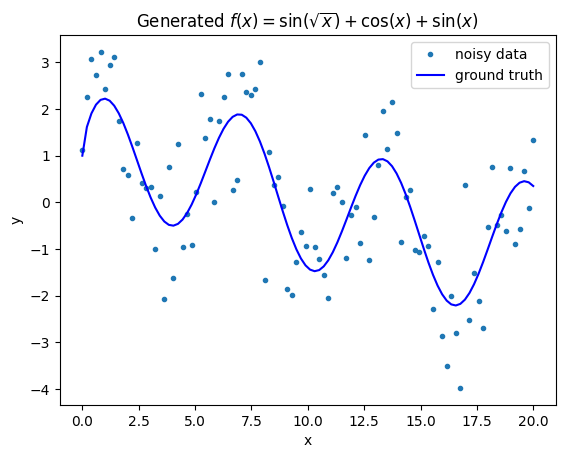

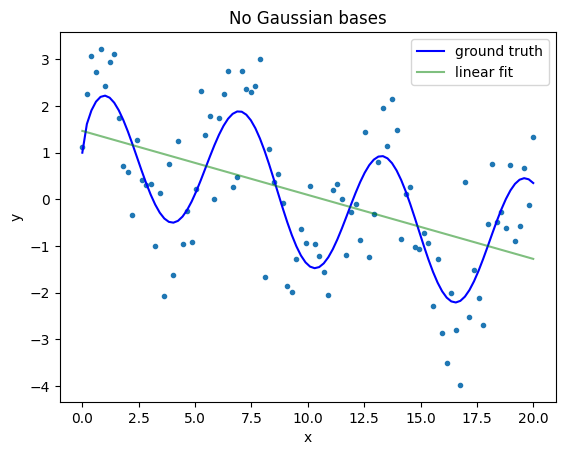

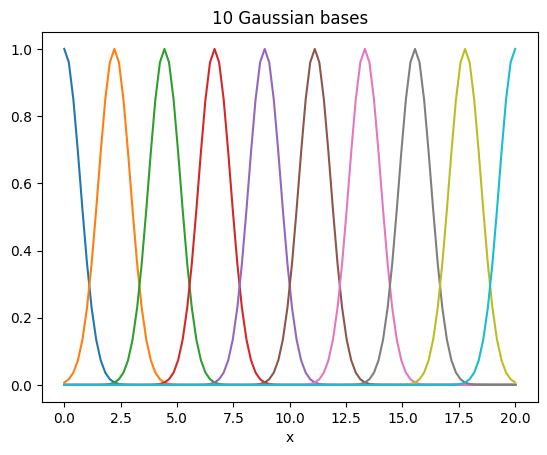

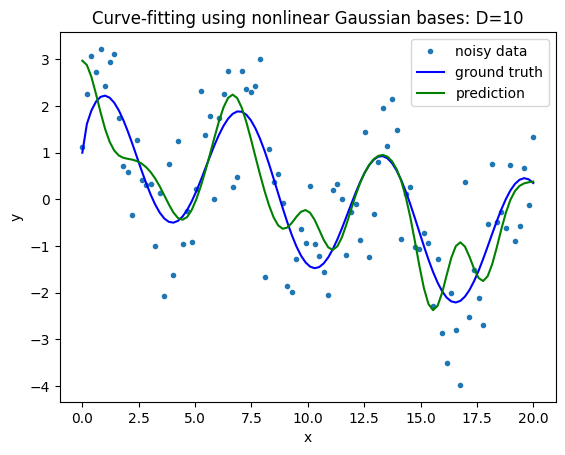

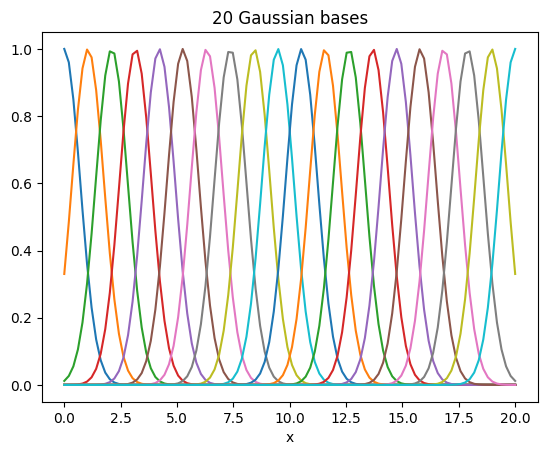

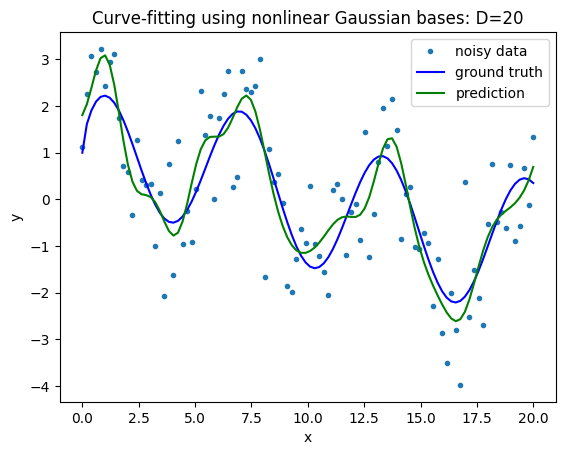

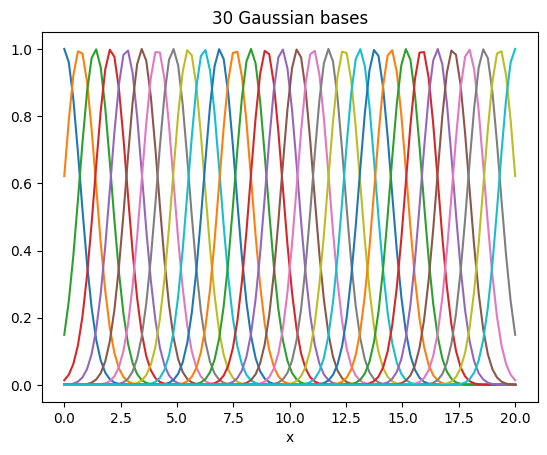

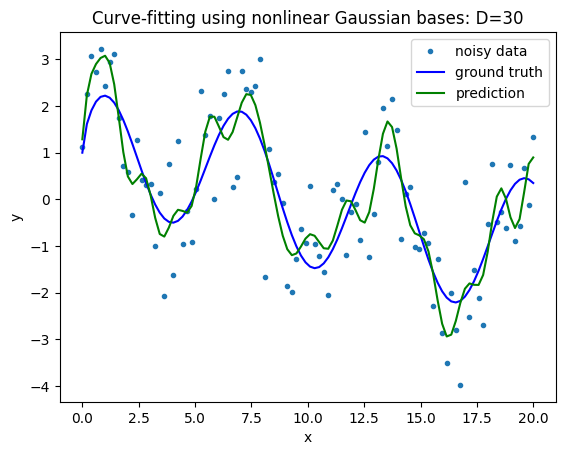

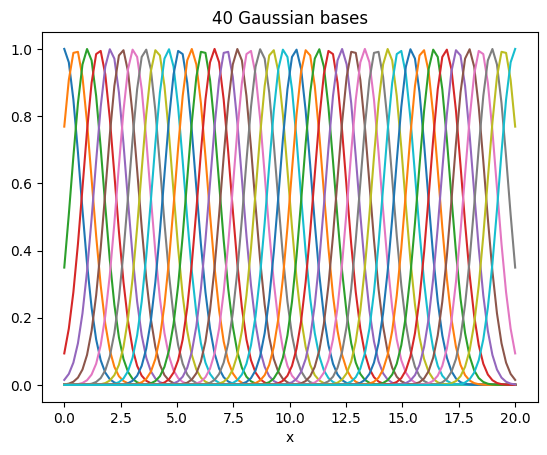

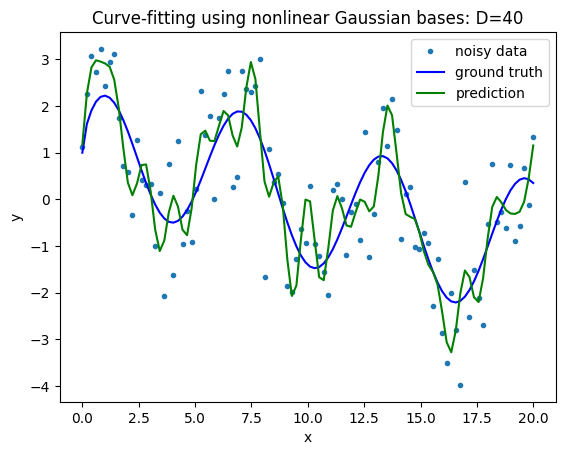

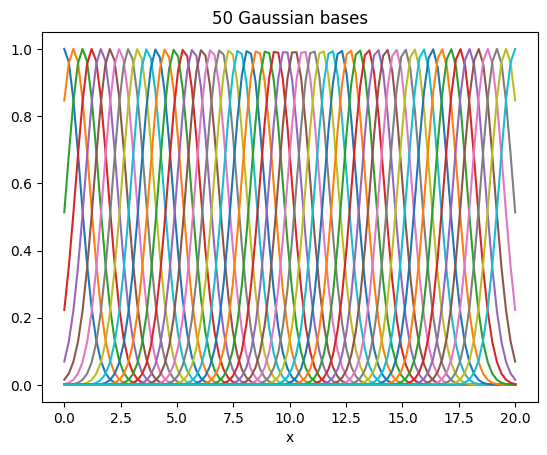

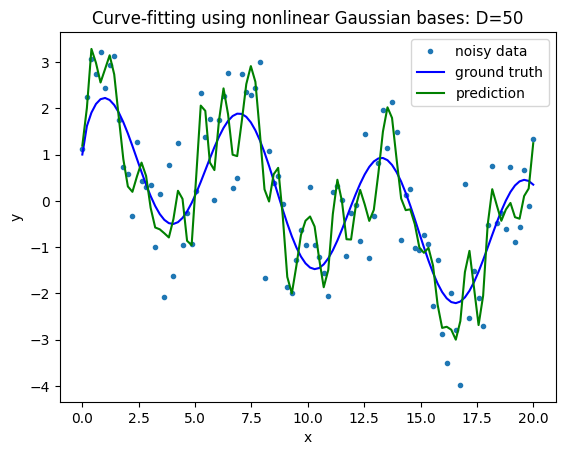

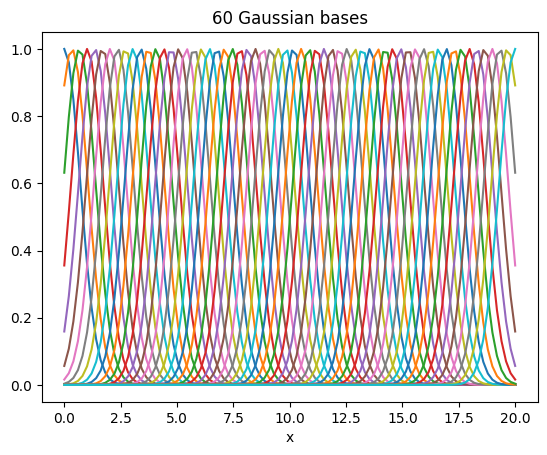

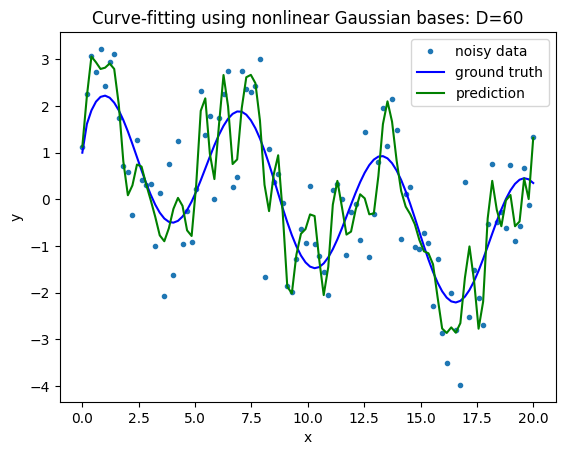

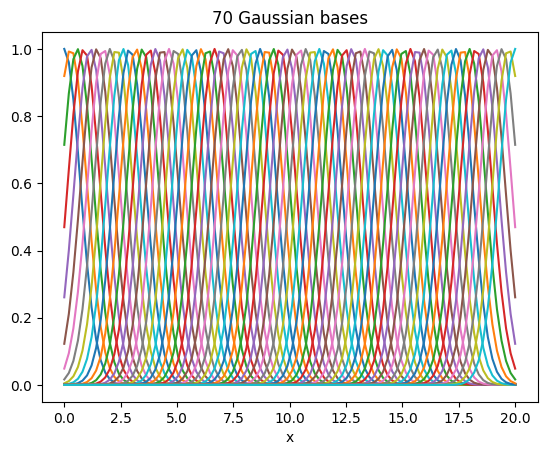

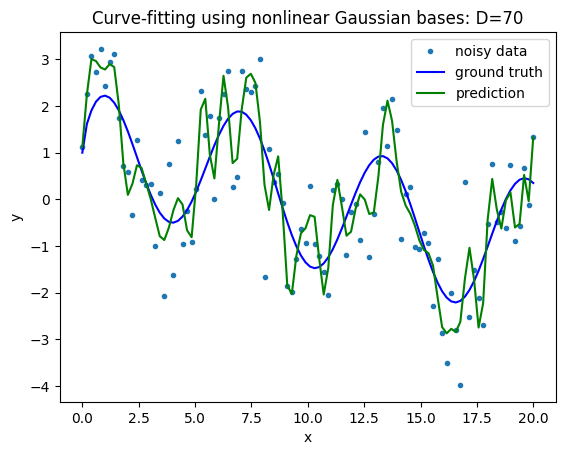

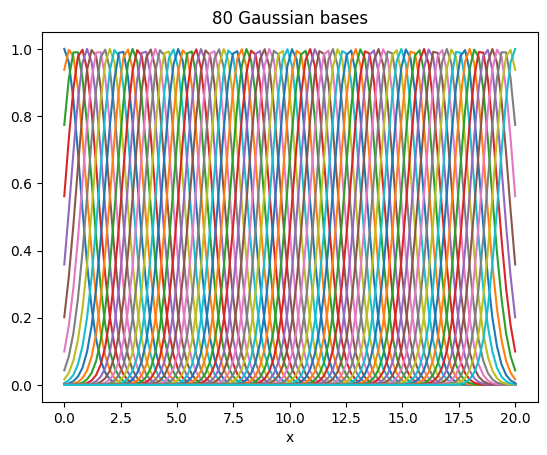

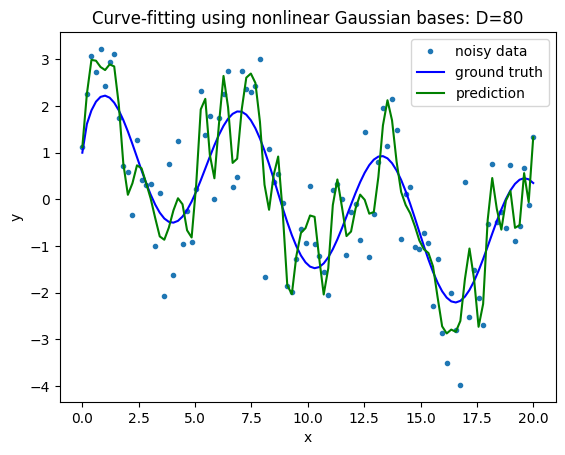

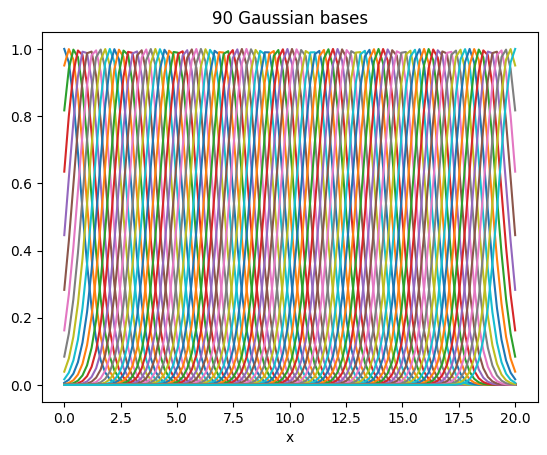

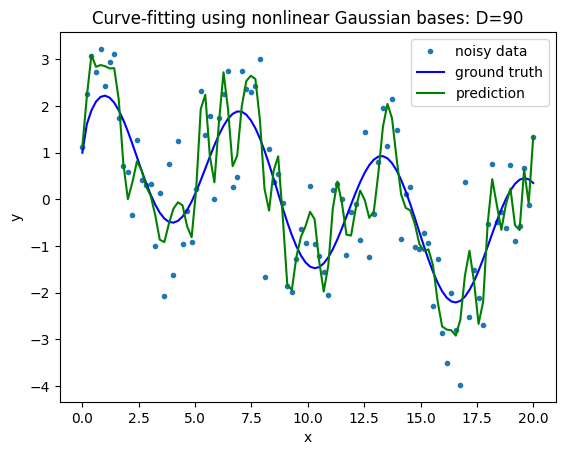

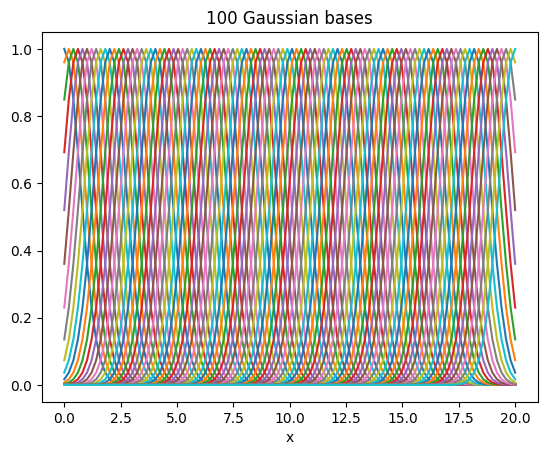

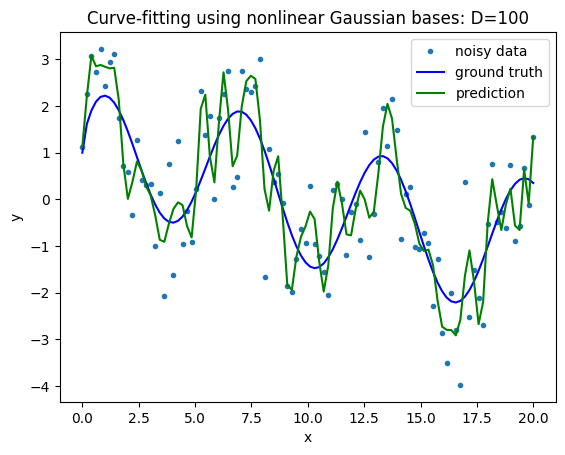

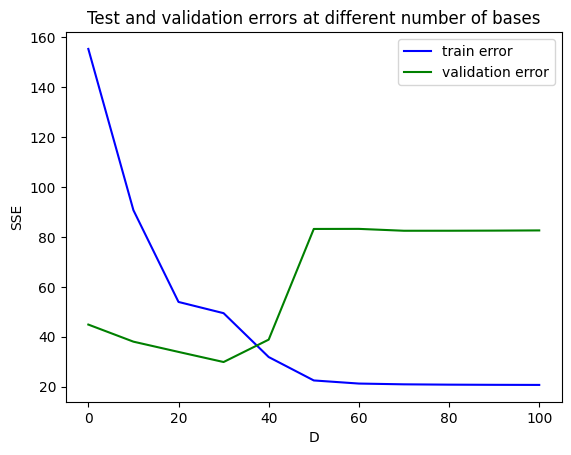

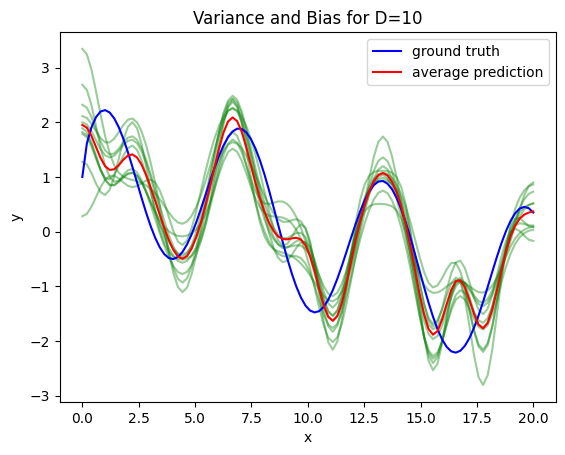

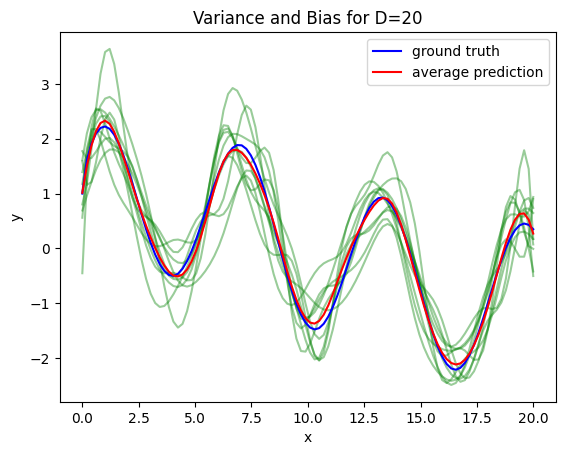

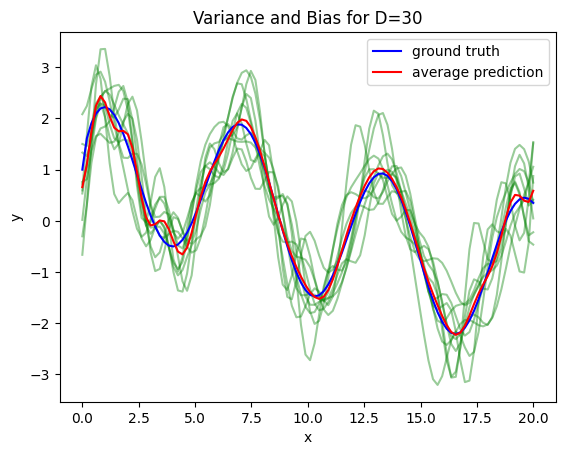

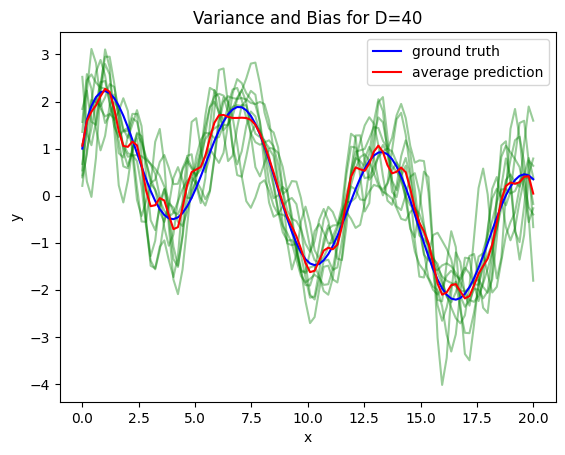

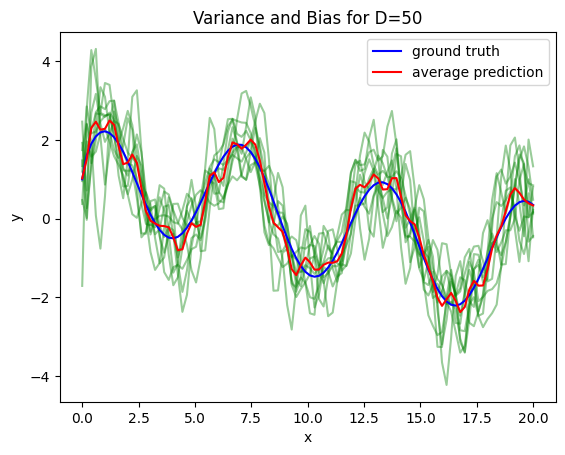

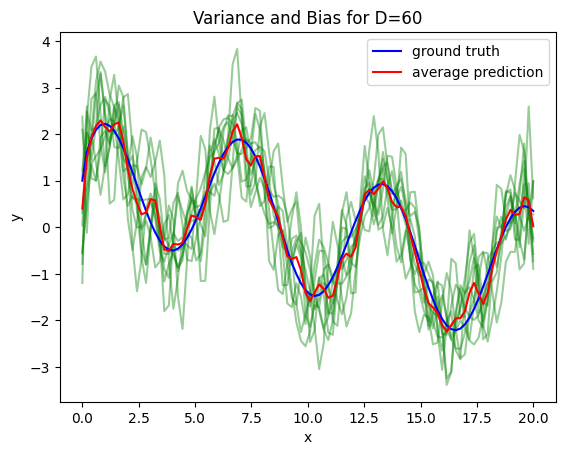

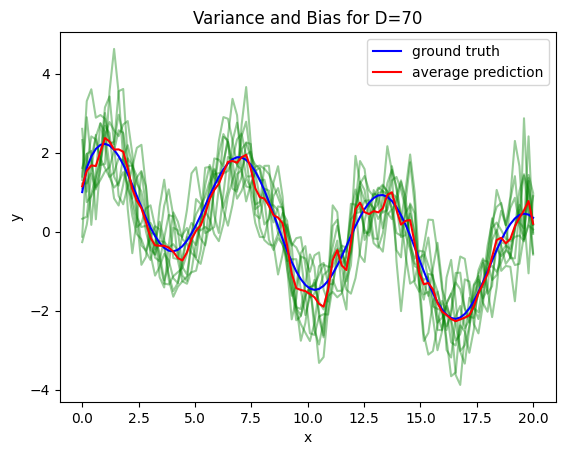

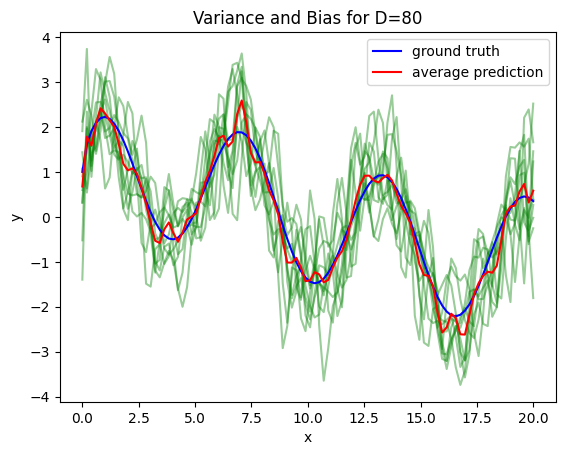

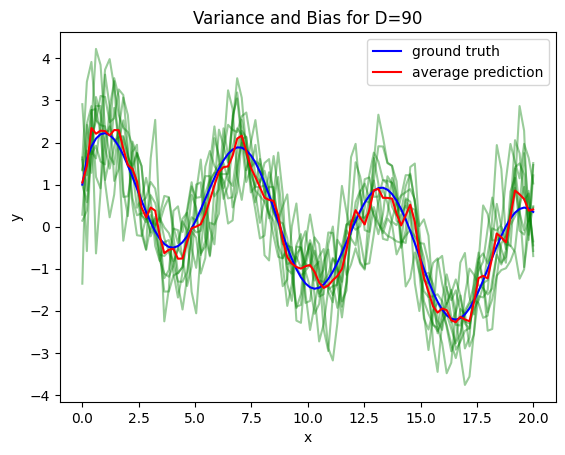

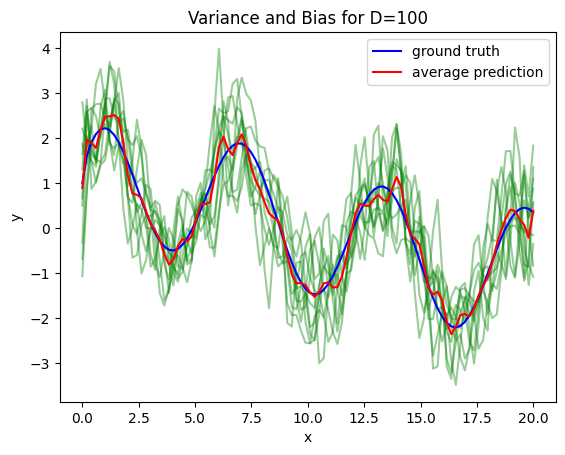

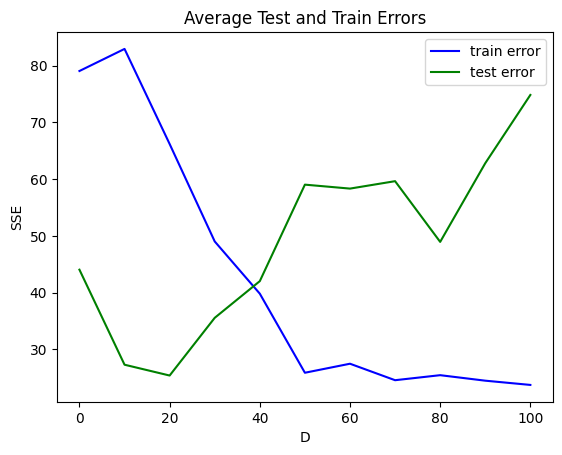

In [ ]:
#%% testing tasks 1 and 2

# generate synthetic data
N = 100
model = LinearRegression()
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
x = np.linspace(0,20, N)
yt = np.sin(x**.5) + np.cos(x) + np.sin(x) # true y function without noise                    
y = yt + np.random.randn(N) # y with noise

# split train and validation datasets
x_train, y_train, x_val, y_val = split_data_train_val(x, y, 0.8)

# task 1.1: plot generated synthetic data
plt.plot(x, y, '.', label='noisy data')
plt.plot(x, yt, 'b-', label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'Generated $f(x) = \sin(\sqrt{x}) + \cos(x) + \sin(x)$')
plt.legend()
plt.show()

# task 1.2 and 1.3: model fitting
get_gaussian_bases(yt, y, x)
# task 1.4: model selection
test_sse_bases(yt, x_train, y_train, x_val, y_val)
# task 2.2: bias-variance of multiple fits
test_variance_bias(yt)
# task 2.3: plotting train and test errors
get_train_test_errors(yt)

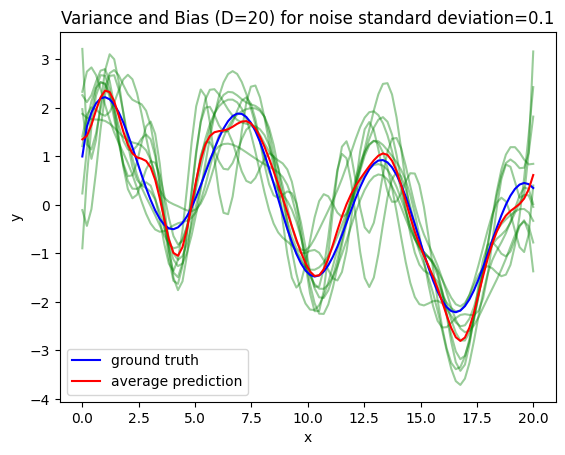

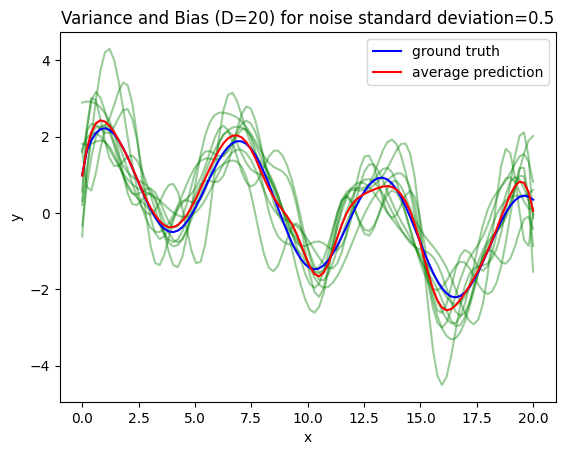

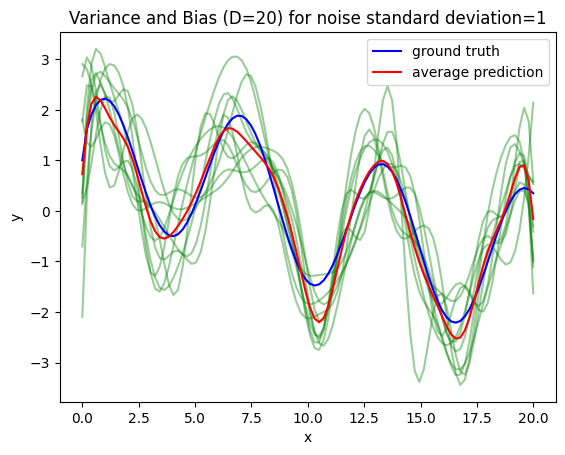

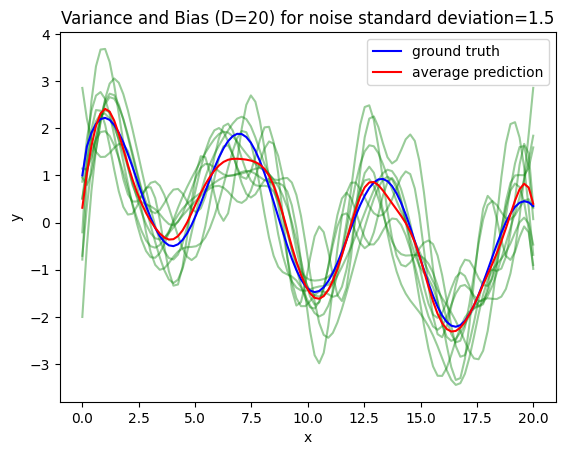

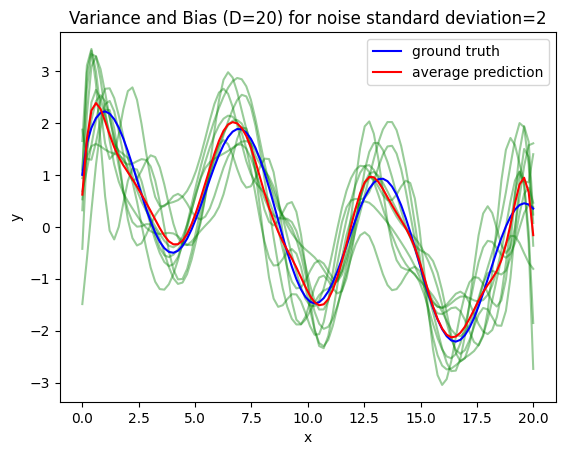

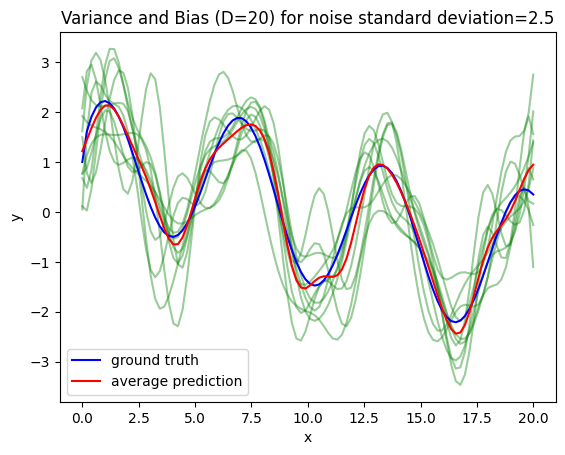

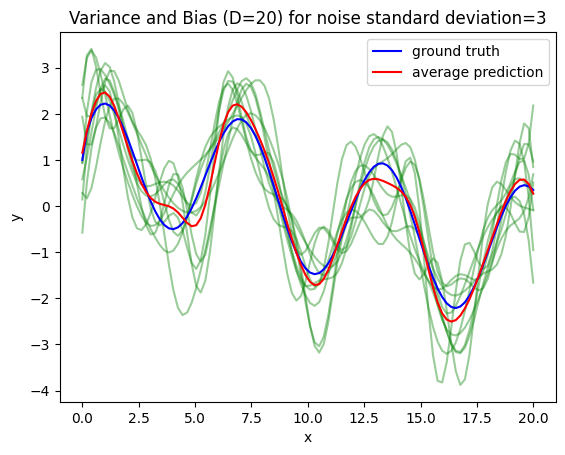

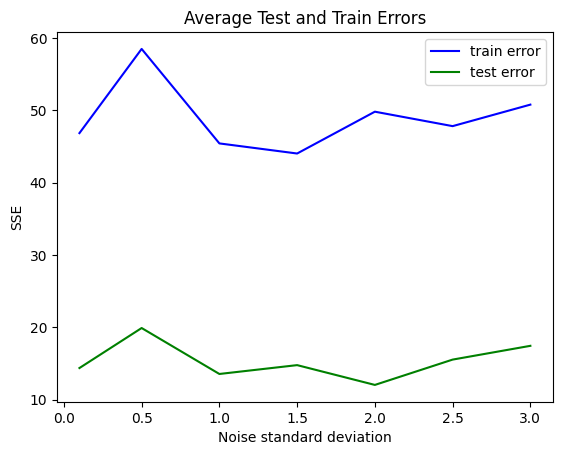

In [ ]:
#%% originality test: different noise levels

# generate synthetic data    
N = 100
model = LinearRegression()
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
x = np.linspace(0,20, N)
yt = np.sin(x**.5) + np.cos(x) + np.sin(x) # true y function without noise
# run tests
test_noise_and_variance_bias(yt)
test_noise_train_test_errors(yt)

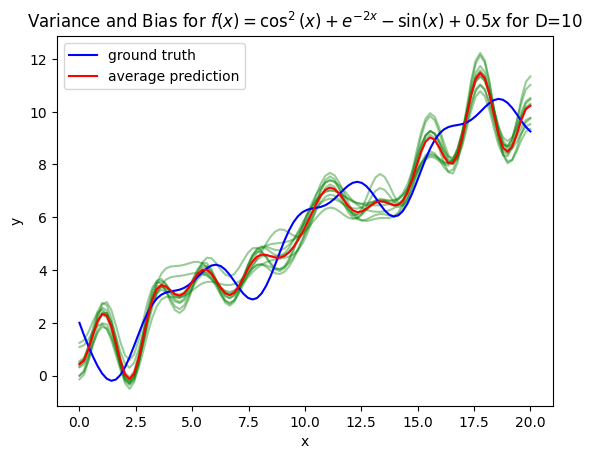

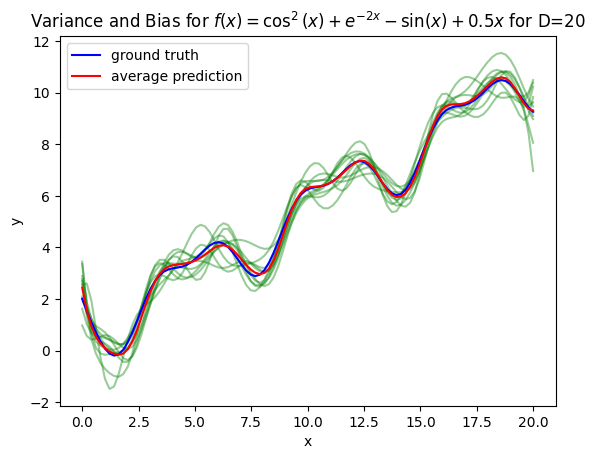

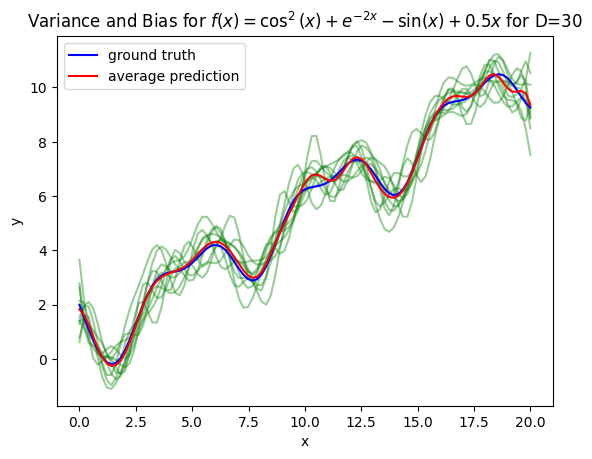

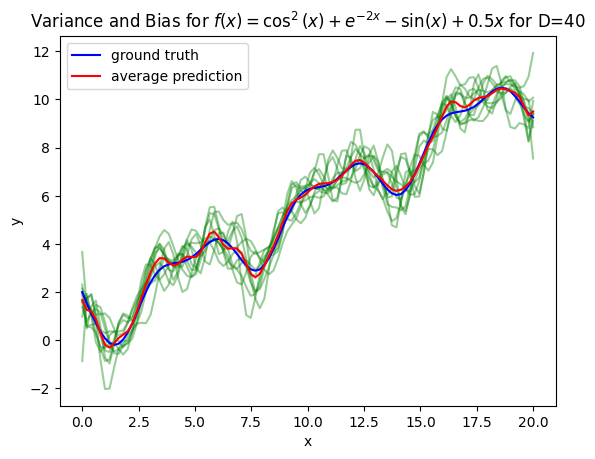

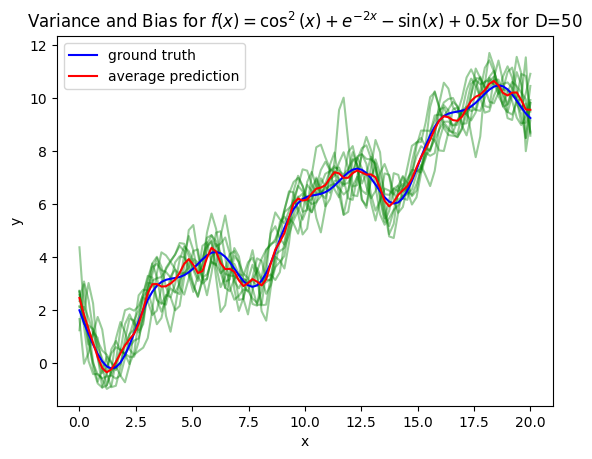

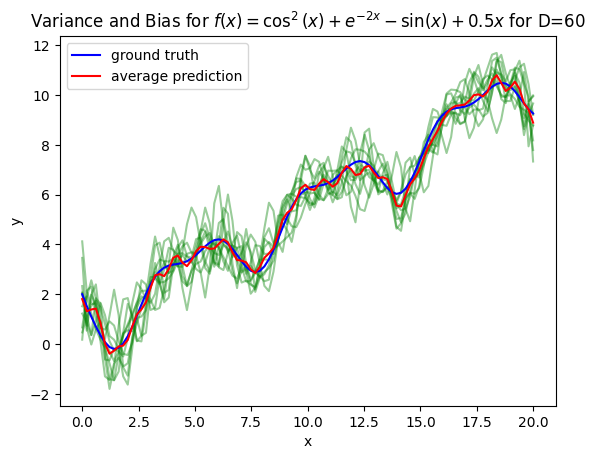

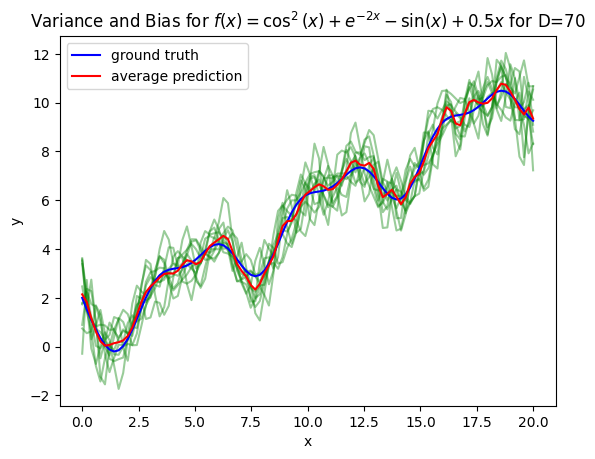

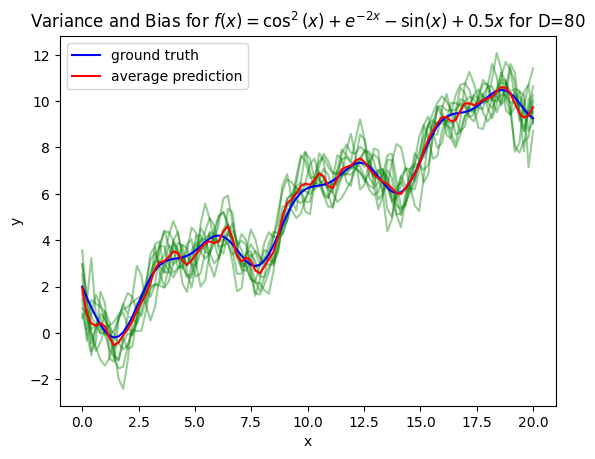

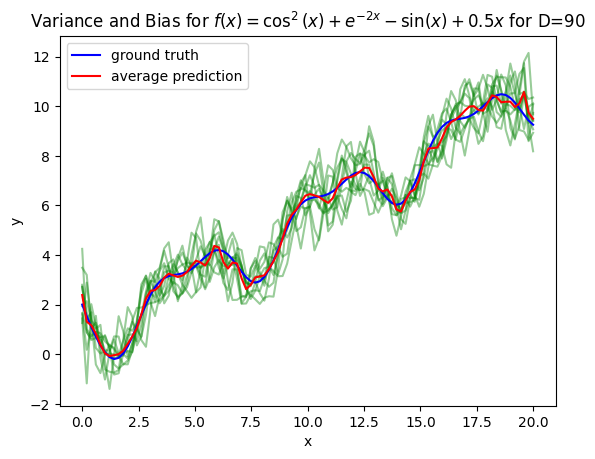

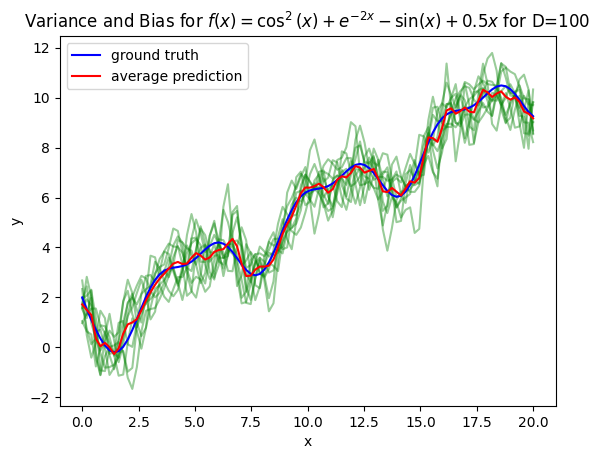

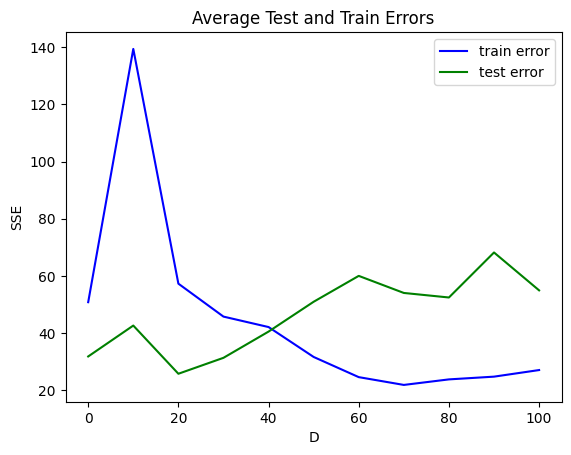

In [ ]:
#%% originality test: different synthetic function

# generate synthetic data
N = 100
model = LinearRegression()
gaussian = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
x = np.linspace(0,20, N)
yt = np.cos(x)**2 + np.exp(-2*x) - np.sin(x) + .5*x # true y function without noise
y = yt + np.random.randn(N) # y with noise
x_train, y_train, x_val, y_val = split_data_train_val(x, y, 0.8)
# run tests
test_variance_bias_new_func()
get_train_test_errors(yt)

Converged at epoch: 976 with loss: 1.346826
Converged at epoch: 966 with loss: 1.181546
Converged at epoch: 975 with loss: 1.329129
Converged at epoch: 976 with loss: 1.336659
Converged at epoch: 972 with loss: 1.288525
Converged at epoch: 978 with loss: 1.342069
Converged at epoch: 979 with loss: 1.345647
Converged at epoch: 969 with loss: 1.231723
Converged at epoch: 985 with loss: 1.290344
Converged at epoch: 969 with loss: 0.723814
Converged at epoch: 863 with loss: 1.366930
Converged at epoch: 854 with loss: 1.203929
Converged at epoch: 862 with loss: 1.349230
Converged at epoch: 863 with loss: 1.355924
Converged at epoch: 860 with loss: 1.307077
Converged at epoch: 867 with loss: 1.362829
Converged at epoch: 865 with loss: 1.365615
Converged at epoch: 857 with loss: 1.249701
Converged at epoch: 870 with loss: 1.309315
Converged at epoch: 857 with loss: 0.739847
Converged at epoch: 763 with loss: 1.385431
Converged at epoch: 755 with loss: 1.224590
Converged at epoch: 762 with los

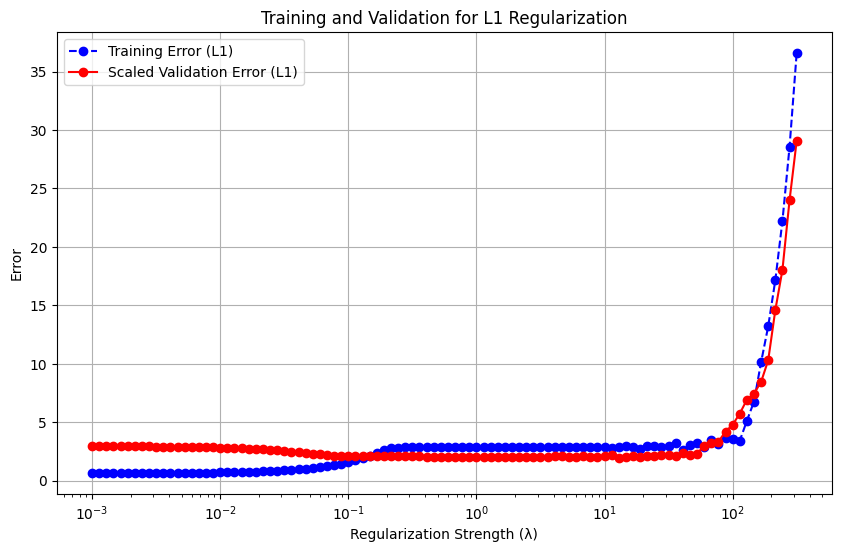

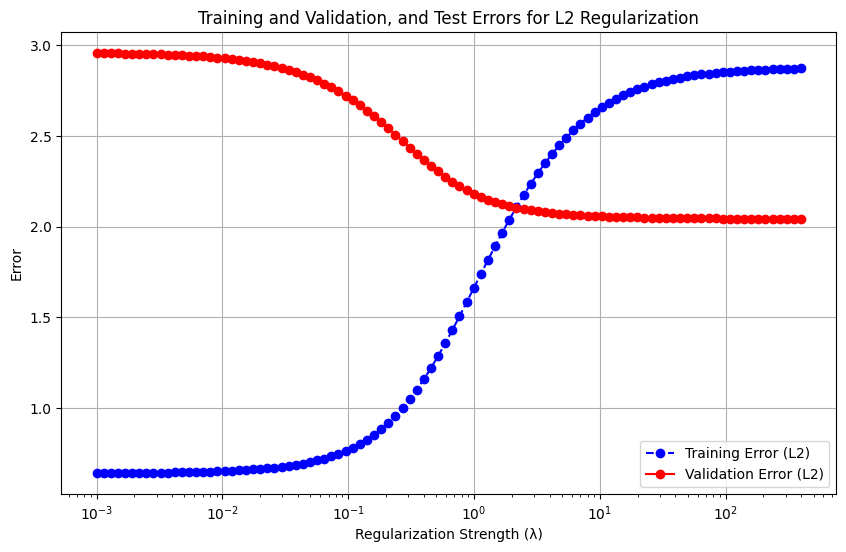

([np.float64(0.6463805904964856),
  np.float64(0.6471518673706804),
  np.float64(0.6480344568867731),
  np.float64(0.6490446681688973),
  np.float64(0.65020268517191),
  np.float64(0.651530780619027),
  np.float64(0.6530571921136723),
  np.float64(0.654811251909531),
  np.float64(0.6568311005433006),
  np.float64(0.6591603624700786),
  np.float64(0.6618508097225442),
  np.float64(0.6649623320009864),
  np.float64(0.6685651199247588),
  np.float64(0.6727394441811778),
  np.float64(0.6775814680593126),
  np.float64(0.6831974540933969),
  np.float64(0.6897275324315153),
  np.float64(0.6973379272713724),
  np.float64(0.7061926756611037),
  np.float64(0.716473510497923),
  np.float64(0.7284008905708926),
  np.float64(0.7421995051407965),
  np.float64(0.7580868606078643),
  np.float64(0.7761802406815201),
  np.float64(0.796990695421385),
  np.float64(0.8211294418311514),
  np.float64(0.8489986594624211),
  np.float64(0.8811851137382627),
  np.float64(0.9179362563492391),
  np.float64(0.96030

In [ ]:
# %% TASK $

task3_1_wz(model,70,10,np.logspace(-3, 2.5, 100),np.logspace(-3, 2.6, 100))

In [ ]:
# %%

#model: LinearRegression, num_features, k, l1_vals, l2_vals, num_datasets, noise_variance=1.0
task3_2_wz(model,70,10,np.logspace(-3, 2, 30),np.logspace(-3, 2, 30),50,noise_variance=2)

Starting Dataset 1/50
(81, 70)
Converged at epoch: 824 with loss: 1.025124
Converged at epoch: 828 with loss: 0.952624
Converged at epoch: 826 with loss: 1.032754
Converged at epoch: 826 with loss: 1.067816
Converged at epoch: 833 with loss: 0.985451
Converged at epoch: 831 with loss: 1.034171
Converged at epoch: 831 with loss: 0.984925
Converged at epoch: 830 with loss: 1.045391
Converged at epoch: 828 with loss: 1.057046
Converged at epoch: 830 with loss: 1.002805
Converged at epoch: 579 with loss: 1.111876
Converged at epoch: 578 with loss: 1.045126
Converged at epoch: 578 with loss: 1.097547
Converged at epoch: 577 with loss: 1.119132
Converged at epoch: 581 with loss: 1.121552
Converged at epoch: 579 with loss: 1.137143
Converged at epoch: 582 with loss: 1.109739
Converged at epoch: 575 with loss: 1.046654
Converged at epoch: 578 with loss: 1.093528
Converged at epoch: 577 with loss: 1.162293
Converged at epoch: 401 with loss: 1.204218
Converged at epoch: 398 with loss: 1.107370
C

In [ ]:
#%%

taskSVD_VSREG(x,y,model,30,10,np.logspace(-10, 3, 100))

In [ ]:
#%% testing task 4

# generate data
N = 50
x = np.linspace(0,10, N)
yt = -4*x + 10 # true y function without noise
y = yt + 2* np.random.randn(N)

# plot loss functions
l1_loss_functions()
l2_loss_functions()
# visualizing gradient descent
visualize_gd(x, y, reg_type='L1') # L1 regularization
visualize_gd(x, y, reg_type='L2') # L2 regularization